In [1]:
import numpy as np
import pyccl as ccl
import camb
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from onepower import Spectra

from defaults_dictionary import kwargs

from matplotlib import rc

rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
rc("text", usetex=True)

plt.rcParams.update({"font.size": 16})

/Users/ferreirat/.pyenv/versions/cosmosis/lib/python3.11/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion


In [5]:
# Cosmmon parameters
# -----------------------

omega_m = 0.3       # Total matter density (cold dark matter + baryonic matter)
omega_c = 0.25      # Cold dark matter density
omega_b = 0.05      # Baryonic matter density

h0 = 0.7            # Dimensionless Hubble parameter
ns = 0.9            # Spectral index

# CAMB settings
# -----------------------
# Cosmology
camb_cosmo = {
    'omch2': omega_c * h0 ** 2,  # Omega_c * h^2 (CDM density)
    'ombh2': omega_b * h0 ** 2,  # Omega_b * h^2 (baryon density)
    'H0': h0 * 100,              # Hubble constant in km/s/Mpc
    'ns': ns,                    # Spectral index
    'As': 2.1e-9,                # Scalar amplitude
}

# Neutrino settings (disabled in this configuration)
no_neutrinos = {
    'num_massive_neutrinos': 0,  # Effective number of massive neutrinos
    'mnu': 0                     # Sum of neutrino masses in eV (set to 0)
}

# Redshift and k-range settings
z = 0
kmin, kmax, nk = 1e-4, 1e1, 5000  # k-range [h/Mpc] and number of points

# OnePower settings
# -----------------------------
# Cosmology
params_cosmo = {
    'omega_c': omega_c,    # Cold dark matter density
    'omega_m': omega_m,    # Total matter density
    'omega_b': omega_b,    # Baryonic matter density
    'h0': h0,              # Dimensionless Hubble parameter
    'n_s': ns,             # Spectral index (note different key name than CAMB)
    'sigma_8': 0.8,        # RMS linear density fluctuation in 8 Mpc/h spheres
#    'm_nu': 0.0,          # Neutrino mass
}

# Power Spectrum
params_pk = {
    'k_vec': np.logspace(-4, 1, 5000),
    'lnk_min': float(np.log(10**(-4.0))),
    'lnk_max': float(np.log(10**(1.0))),
    'dlnk': float((np.log(10**(1.0)) - np.log(10**(-4.0))) / 5000),
    'z_vec': [0.0],
    'growth_model': 'CambGrowth',
}

## Transfer Function

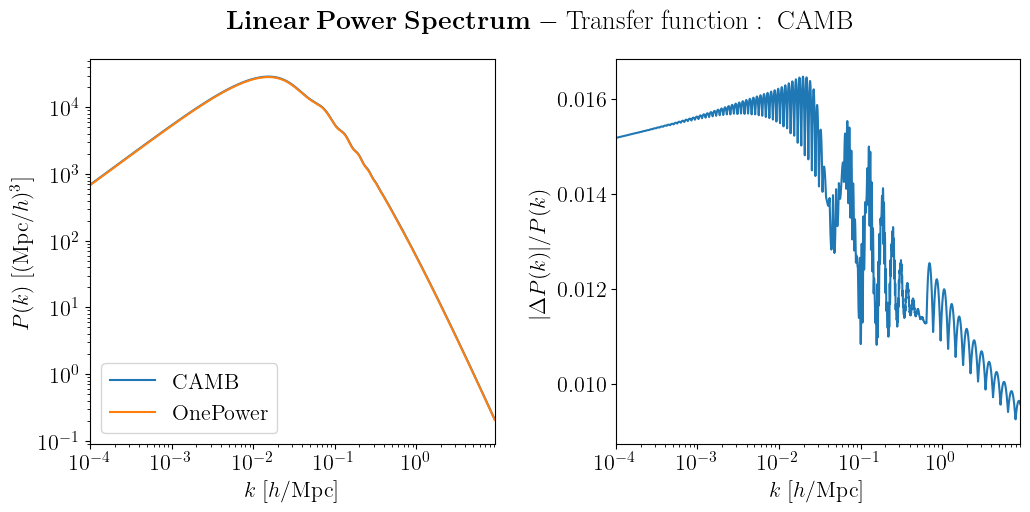

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3,hspace=0.5)


# =================================================================================
# CAMB Power Spectrum
# =================================================================================

cp = camb.set_params(
    **camb_cosmo,
    **no_neutrinos)

cp.set_matter_power(redshifts=[z], kmax=kmax, nonlinear=False)

results = camb.get_results(cp)
powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_lin = powerspec

ax1.plot(kh, camb_pk_lin[0], label="$\mathrm{CAMB}$")

# =================================================================================
# Transfer Function from CAMB (for Onepower)
# =================================================================================

camb_transfers = camb.get_transfer_functions(cp)
transfer_func = results.get_matter_transfer_data().transfer_z("delta_tot")
transfer_k = results.get_matter_transfer_data().transfer_z("k/h")

# =================================================================================
# Onepower Power Spectrum
# =================================================================================

model_CAMB = Spectra(
        m_nu=0.0,
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        **params_cosmo, **params_pk, **kwargs)

ax1.plot(model_CAMB.kh, model_CAMB.power[0,:], label="$\mathrm{OnePower}$")

# =================================================================================
# Relative Difference
# =================================================================================

diff_CAMB = (model_CAMB.power[0,:] - camb_pk_lin[0])/camb_pk_lin[0]

ax2.plot(kh, np.abs(diff_CAMB))


ax1.legend()

ax1.set(xlim=(1e-4, 9.13),
        xscale="log",
        yscale="log",
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$P(k) \ [(\mathrm{Mpc}/h)^3]$")

ax2.set(xlim=(1e-4, 9.13),
#        ylim=(0.5, 1.5),
        xscale="log",
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$| \Delta P(k) | / P(k)$")

fig.suptitle("$\mathbf{Linear\ Power\ Spectrum}\ \mathrm{-\ Transfer\ function:\ CAMB}$")

plt.savefig("Pk_linear_compare_transferCAMB.pdf",
            bbox_inches="tight",
            dpi=300)

plt.show()

## Transfer function and neutrinos

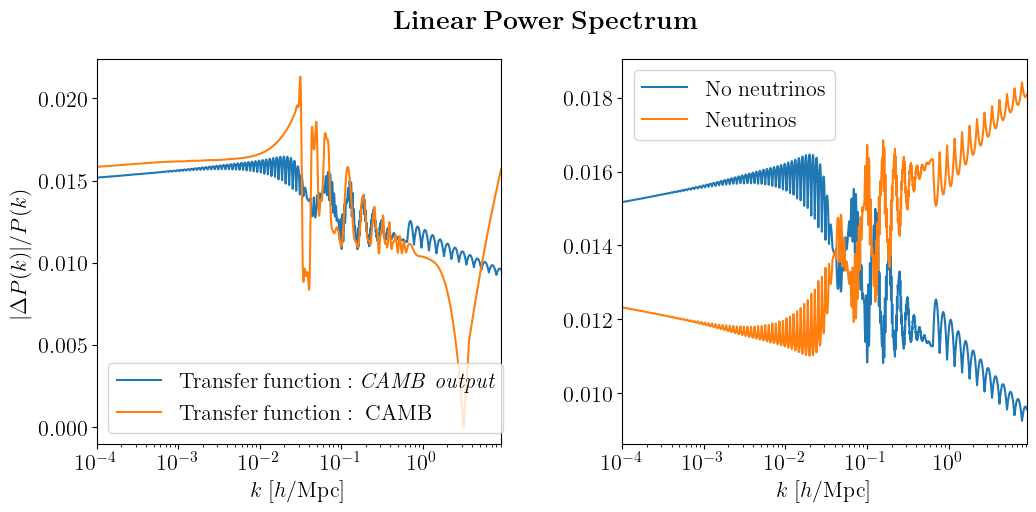

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3,hspace=0.5)

# =================================================================================
# Transfer function check
# =================================================================================

# Transfer model = CAMB output

cp = camb.set_params(
    **camb_cosmo,
    **no_neutrinos)

cp.set_matter_power(redshifts=[z], kmax=kmax, nonlinear=False)

results = camb.get_results(cp)
powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_lin = powerspec

camb_transfers = camb.get_transfer_functions(cp)
transfer_func = results.get_matter_transfer_data().transfer_z("delta_tot")
transfer_k = results.get_matter_transfer_data().transfer_z("k/h")

model_CAMB = Spectra(
        mead_correction='None',
        m_nu=0.0,
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        **params_cosmo, **params_pk, **kwargs)

# Relative Differences

diff_CAMB = (model_CAMB.power[0,:] - camb_pk_lin[0])/camb_pk_lin[0]
ax1.plot(kh, np.abs(diff_CAMB), label="$\mathrm{Transfer\ function:}$ $\mathit{CAMB\ output}$")

# Transfer model = 'CAMB'

model_NoCAMB = Spectra(
        mead_correction='None',
        m_nu=0.0,
        transfer_model='CAMB',
        **params_cosmo, **params_pk, **kwargs)

# Relative Differences

diff_noCAMB = (model_NoCAMB.power[0,:] - camb_pk_lin[0])/camb_pk_lin[0]
ax1.plot(kh, np.abs(diff_noCAMB), label="$\mathrm{Transfer\ function:\ CAMB}$")

# =================================================================================
# Neutrinos check
# =================================================================================

# Onepower Power Spectrum - no neutrinos

model_CAMB_NoNeutrinos = Spectra(
        mead_correction='None',
        m_nu=0.0,
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        **params_cosmo, **params_pk, **kwargs)

# Relative Differences

diff_NoNeutrinos = (model_CAMB_NoNeutrinos.power[0,:] - camb_pk_lin[0])/camb_pk_lin[0]
ax2.plot(kh, np.abs(diff_NoNeutrinos), label="$\mathrm{No\ neutrinos}$")

# ================

# CAMB Power Spectrum - neutrinos

cp = camb.set_params(
    **camb_cosmo)

cp.set_matter_power(redshifts=[z], kmax=kmax, nonlinear=False)

results = camb.get_results(cp)
powerspec = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, camb_pk_lin_Neutrinos = powerspec

camb_transfers = camb.get_transfer_functions(cp)
transfer_func = results.get_matter_transfer_data().transfer_z("delta_tot")
transfer_k = results.get_matter_transfer_data().transfer_z("k/h")

# Onepower Power Spectrum - neutrinos

model_CAMB_Neutrinos = Spectra(
        mead_correction='None',
        m_nu=0.06,
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        **params_cosmo, **params_pk, **kwargs)

# Relative Differences

diff_Neutrinos = (model_CAMB_Neutrinos.power[0,:] - camb_pk_lin_Neutrinos[0])/camb_pk_lin_Neutrinos[0]
ax2.plot(kh, np.abs(diff_Neutrinos), label="$\mathrm{Neutrinos}$")

ax1.legend()
ax2.legend()

ax1.set(xlim=(1e-4, 9.13),
        xscale="log",
#        yscale="log",
        xlabel=r"$k \ [h/\mathrm{Mpc}]$",
        ylabel=r"$| \Delta P(k) | / P(k)$")

ax2.set(xlim=(1e-4, 9.13),
#        ylim=(0.5, 1.5),
        xscale="log",
        xlabel=r"$k \ [h/\mathrm{Mpc}]$")

fig.suptitle("$\mathbf{Linear\ Power\ Spectrum}$")

plt.savefig("Pk_linear_comparisons.pdf",
            bbox_inches="tight",
            dpi=300)

plt.show()

## Accuracy Settings

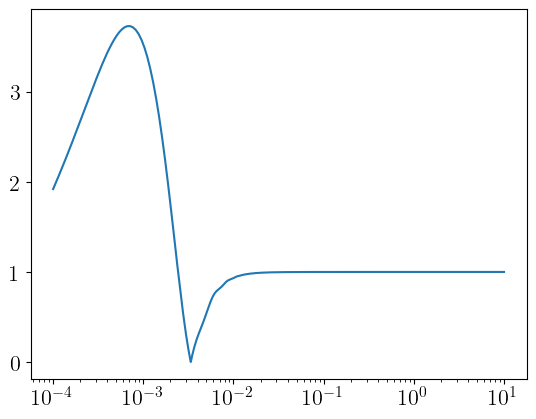

In [67]:
# =================================================================================
# Change accuracy
# =================================================================================

# CAMB settings
kmin_, kmax_, nk_ = 1e-4, 1e1, 16000

# OnePower settings
params_accuracy = {
    'k_vec': np.logspace(-4, 1, 16000),
    'lnk_min': float(-8),
    'lnk_max': float(8),
    'dlnk': float(0.001),
    'z_vec': [0.0],
    'growth_model': 'CambGrowth',
}

# =================================================================================
# CAMB Power Spectrum
# =================================================================================

cp = camb.set_params(
    **camb_cosmo,
    **no_neutrinos)

cp.set_matter_power(redshifts=[z], kmax=kmax_, nonlinear=False)

results = camb.get_results(cp)
powerspec = results.get_matter_power_spectrum(minkh=kmin_, maxkh=kmax_, npoints=nk_)
kh, z_, camb_pk_lin_accuracy = powerspec

# =================================================================================
# Transfer Function from CAMB (for Onepower)
# =================================================================================

camb_transfers = camb.get_transfer_functions(cp)
transfer_func = results.get_matter_transfer_data().transfer_z("delta_tot")
transfer_k = results.get_matter_transfer_data().transfer_z("k/h")

# =================================================================================
# Onepower Power Spectrum
# =================================================================================

model_accuracy = Spectra(
        m_nu=0.0,
        transfer_model='FromArray',
        transfer_params={'k': transfer_k, 'T': transfer_func},
        **params_cosmo, **params_accuracy, **kwargs)

# =================================================================================
# Relative Difference
# =================================================================================

diff_accuracy = (model_accuracy.power[0,:] - camb_pk_lin_accuracy[0])/camb_pk_lin_accuracy[0]

plt.plot(kh, np.abs(diff_accuracy))

plt.xscale('log')
plt.show()